<a href="https://colab.research.google.com/github/Abrazacs/course_work_ml/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_ML_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_CC50_%3E_%D0%BC%D0%B5%D0%B4%D0%B8%D0%B0%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%load_ext cuml.accel

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [ ]:
# Базовые переменные
target_column = 'CC50, mM'
target_upper_border = 2079.43
colums_to_drop = ['Unnamed: 0', 'SI', 'IC50, mM']
grid_search_scoring = 'roc_auc'

In [ ]:
# словарь моделей
models_config = {
    'KNN' : {
      'model' : KNeighborsClassifier(),
      'params' : {
          'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'leaf_size': [10, 20, 30, 40, 50],
          'p': [1, 2]
      }
    },
    'RandomForest' : {
        'model' : RandomForestClassifier(random_state=42),
        'params' : {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20, 30, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 4, 6],
            'max_features': ['sqrt', 5, 10, 20]
        }
    },
    'AdaBoost' : {
        'model' : AdaBoostClassifier(random_state=42),
        'params' : {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.2, 0.3],
            'estimator': [
                DecisionTreeClassifier(max_depth=1),
                DecisionTreeClassifier(max_depth=2),
                DecisionTreeClassifier(max_depth=3)
            ]
        }
    }
}

In [ ]:
# Базовые преобразования

df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')
df.dropna(inplace=True)
df = df[df[target_column]<=target_upper_border]
df.drop(colums_to_drop, axis=1, inplace=True)

X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование целевой переменной на основе медианы в тренировочной выборке
train_y_median= y_train.median()
y_train = (y_train > train_y_median).astype(int)
y_test = (y_test > train_y_median).astype(int)

In [ ]:
# создаем датафрейм для хранения результатов
resulst_df = pd.DataFrame(columns=['model_name',
                                   'params',
                                   'train_roc_auc',
                                   'test_roc_auc',
                                   'test_accuracy',
                                   'test_precision',
                                   'test_recall',
                                   'test_f1'])

def add_result(model_name, params, scores_dict):

  """
  Функция для добавления результатов в датафрейм
  """

  global resulst_df
  new_row = {'model_name': model_name,
             'params': params,
             'train_roc_auc': scores_dict['train_roc_auc'],
             'test_roc_auc': scores_dict['test_roc_auc'],
             'test_accuracy': scores_dict['test_accuracy'],
             'test_precision': scores_dict['test_precision'],
             'test_recall': scores_dict['test_recall'],
             'test_f1': scores_dict['test_f1']
             }

  resulst_df = pd.concat([resulst_df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
def train_models_and_print_results(models_config, X_train, y_train, X_test, y_test, model_name_postfix=''):

  """
  Функция для обучения моделей и вывода результатов
  """

  for model_name, model_config in models_config.items():

    grid_search = GridSearchCV(estimator= model_config['model'],
                               param_grid=model_config['params'],
                               cv=5,
                               scoring=grid_search_scoring,
                               n_jobs=-1,
                               verbose=2)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    scores_dict = {
        'train_roc_auc': grid_search.best_score_,
        'test_roc_auc': roc_auc_score(y_test, y_pred),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred)
    }


    model_name = model_name + model_name_postfix

    add_result(model_name,
               grid_search.best_params_,
               scores_dict)

    print(f'====================== {model_name} ===========================')
    print(f'Best params: {grid_search.best_params_}')
    print(f'Train ROC AUC: {grid_search.best_score_}')
    print(f'Test ROC AUC: {roc_auc_score(y_test, y_pred)}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Test Precision: {precision_score(y_test, y_pred)}')
    print(f'Test Recall: {recall_score(y_test, y_pred)}')
    print(f'Test F1-score: {scores_dict["test_f1"]}')
    print('================================================================\n')

# Без стандартизации

In [ ]:
train_models_and_print_results(models_config, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
====================== KNN ===========================
Best params: {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Train ROC AUC: 0.6579990412868062
Test ROC AUC: 0.6407487791644059
Test Accuracy: 0.640625
Test Precision: 0.648936170212766
Test Recall: 0.6288659793814433
Test F1-score: 0.6387434554973822

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
====================== RandomForest ===========================
Best params: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Train ROC AUC: 0.8330429823081907
Test ROC AUC: 0.7449267498643517
Test Accuracy: 0.7447916666666666
Test Precision: 0.7553191489361702
Test Recall: 0.7319587628865979
Test F1-score: 0.743455497382199

Fitting 5 folds for each of 27 candidates, totalling 135 fits
====================== AdaBoost ===========================
Best params:

# Добавляем StandardScaler

In [ ]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

train_models_and_print_results(models_config, X_train_std, y_train, X_test_std, y_test, '_std_scaler')

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
====================== KNN_std_scaler ===========================
Best params: {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Train ROC AUC: 0.8212634597118533
Test ROC AUC: 0.7497558328811721
Test Accuracy: 0.75
Test Precision: 0.7425742574257426
Test Recall: 0.7731958762886598
Test F1-score: 0.7575757575757576

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
====================== RandomForest_std_scaler ===========================
Best params: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Train ROC AUC: 0.8334051628480882
Test ROC AUC: 0.7293543136190994
Test Accuracy: 0.7291666666666666
Test Precision: 0.7419354838709677
Test Recall: 0.711340206185567
Test F1-score: 0.7263157894736842

Fitting 5 folds for each of 27 candidates, totalling 135 fits
====================== AdaBoost_std_scaler ===========

# MinMaxScaler + FeatureSelection

In [ ]:
min_max_scaler = MinMaxScaler()
X_train_mm = min_max_scaler.fit_transform(X_train)
X_test_mm = min_max_scaler.transform(X_test)

feature_selector = SelectKBest(chi2, k=20)
X_train_mm = feature_selector.fit_transform(X_train_mm, y_train)
X_test_mm = feature_selector.transform(X_test_mm)

train_models_and_print_results(models_config, X_train_mm, y_train, X_test_mm, y_test, '_min_max_scaler + feature_selector')

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
====================== KNN_min_max_scaler + feature_selector ===========================
Best params: {'algorithm': 'kd_tree', 'leaf_size': 40, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Train ROC AUC: 0.7793601477128476
Test ROC AUC: 0.6669560499186109
Test Accuracy: 0.6666666666666666
Test Precision: 0.6813186813186813
Test Recall: 0.6391752577319587
Test F1-score: 0.6595744680851063

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
====================== RandomForest_min_max_scaler + feature_selector ===========================
Best params: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Train ROC AUC: 0.8054438043159848
Test ROC AUC: 0.7602821486706457
Test Accuracy: 0.7604166666666666
Test Precision: 0.7575757575757576
Test Recall: 0.7731958762886598
Test F1-score: 0.7653061224489796

Fitting 5 folds for each of 27 candidates, totalling 135

# KernelPCA

In [ ]:
# Подбираем параметры для kernelPCA
kernel_pca_grid = {
    'kpca__kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'kpca__gamma': [0.001, 0.01, 0.1],
    'kpca__n_components': [10, 20, 30, 50],
    'knn__n_neighbors': [3, 5, 7]
}

pipe_kpca_knn = Pipeline([
    ('kpca', KernelPCA(fit_inverse_transform=False)),
    ('knn', KNeighborsClassifier())
])

grid_kpca_knn = GridSearchCV(pipe_kpca_knn, kernel_pca_grid, cv=5, scoring=grid_search_scoring, n_jobs=-1)
grid_kpca_knn.fit(X_train_std, y_train)

best_kpca_params = {k.replace('kpca__', ''): v for k, v in grid_kpca_knn.best_params_.items() if k.startswith('kpca')}

print(f"Лучшие параметры для kernelPCA на основе KNN: {best_kpca_params}")
print(f'======================================================================')

Лучшие параметры для kernelPCA на основе KNN: {'gamma': 0.001, 'kernel': 'poly', 'n_components': 50}


In [ ]:
best_kpca = KernelPCA(**best_kpca_params)
X_train_kpca = best_kpca.fit_transform(X_train_std)
X_test_kpca = best_kpca.transform(X_test_std)

train_models_and_print_results(models_config, X_train_kpca, y_train, X_test_kpca, y_test, ' + StandardScaler + kernelPCA')

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
====================== KNN + StandardScaler + kernelPCA ===========================
Best params: {'algorithm': 'kd_tree', 'leaf_size': 40, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
Train ROC AUC: 0.8147195763907998
Test ROC AUC: 0.7395550732501357
Test Accuracy: 0.7395833333333334
Test Precision: 0.7422680412371134
Test Recall: 0.7422680412371134
Test F1-score: 0.7422680412371134

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
====================== RandomForest + StandardScaler + kernelPCA ===========================
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train ROC AUC: 0.8232636638822559
Test ROC AUC: 0.760607704829083
Test Accuracy: 0.7604166666666666
Test Precision: 0.7741935483870968
Test Recall: 0.7422680412371134
Test F1-score: 0.7578947368421053

Fitting 5 folds for each of 27 candidates, totalling 135 fits


# Итоги

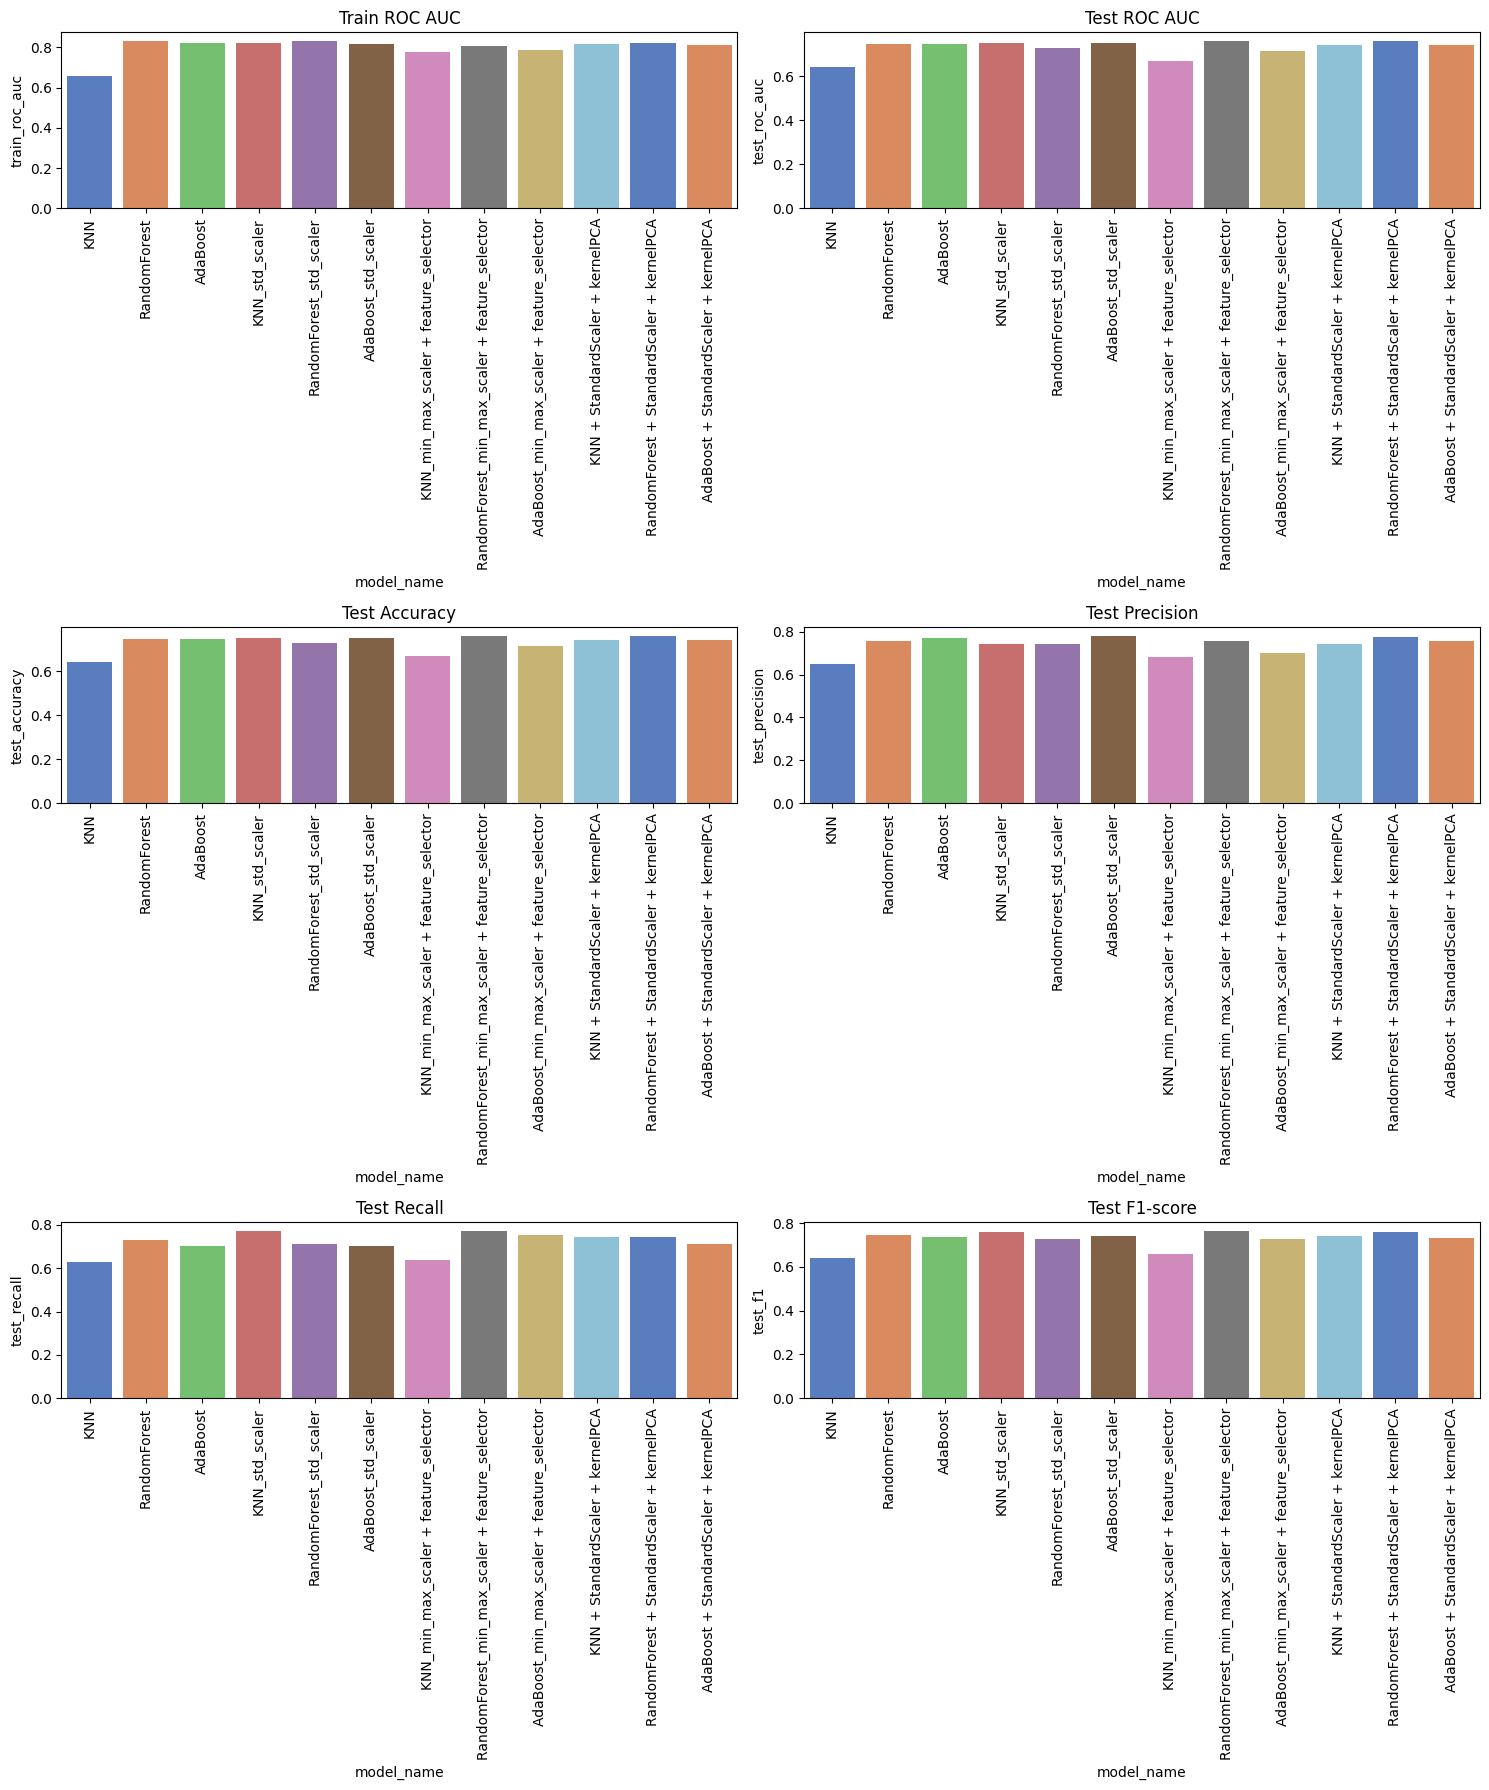

In [ ]:
x_column = 'model_name'
y_column_name_map = {
    'Train ROC AUC' : 'train_roc_auc',
    'Test ROC AUC' : 'test_roc_auc',
    'Test Accuracy' : 'test_accuracy',
    'Test Precision' : 'test_precision',
    'Test Recall' : 'test_recall',
    'Test F1-score' : 'test_f1'
}

def draw_comparing_score_barplot(x, y_col, title, i_idx, j_idx, df, axes):
  sns.barplot(x=x, y=y_col, data=df, ax=axes[i_idx, j_idx], palette='muted')
  axes[i_idx, j_idx].set_title(title)
  axes[i_idx, j_idx].tick_params(axis='x', rotation=90)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

for idx, (title, y_col) in enumerate(y_column_name_map.items()):
  i_idx = idx // 2
  j_idx = idx % 2
  draw_comparing_score_barplot(x_column, y_col, title, i_idx, j_idx, resulst_df, axes)

plt.tight_layout()
plt.show()